# EDA

## Importing modules

And configuting settings

In [251]:
from warnings import filterwarnings
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pandas_profiling as pp
import seaborn as sns
import sweetviz as sv

from scipy.stats import yeojohnson, zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

# import category_encoders as ce

from lib.data_viz_functions import *
from lib.model_related import *

In [3]:
filterwarnings("ignore")
sns.set()

pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

%matplotlib inline

In [642]:
train = pd.read_pickle("data/2022-04-06_train_preprocessed.pkl.zip", compression="zip")
test = pd.read_pickle("data/2022-04-06_test_preprocessed.pkl.zip", compression="zip")

In [672]:
currency_dict= {
    '2020-10-20': 77.9241,
    '2020-10-19': 77.9644,
    '2020-10-21': 77.7780,
    '2020-10-25': 76.4667,
    '2020-10-24': 76.4667,
    '2020-10-26': 76.4667,
    '2020-09-09': 75.9645,
    '2021-09-27': 73.0081,
    '2021-09-30': 72.7608,
    '2021-09-26': 73.0081,
    '2021-09-28': 72.6613,
    '2021-09-29': 72.5083,
    '2021-10-01': 72.6642
}

In [671]:
train[train['sample'] == 'jane']['parsed_date'].value_counts()

2021-09-27    11199
2021-09-30     7287
2021-09-26     5346
2021-09-28     3769
2021-09-29     2372
2021-10-01        4
Name: parsed_date, dtype: int64

## Feature description

- **body_type** - Type of vehicle body (седан, купе, хэтчбек...)  
- **brand** - Manufacture name (bmw, audi...)  
- **color** - Main car's body color  
- **description** - Seller's car description  
- **engine_displacement** - Volume of car's engine (nan if electro)  
- **engine_power** - Engine power in horse powers  
- **fuel_type** - Fuel type (diesel, gasoline, electro...)  
- **km_age** - Vehicle mileage  
- **model_year** - Year when model production was started  
- **number_of_doors** - Number of doors  
- **production_year** - Production year of this car  
- **vehicle_transmission** - Transmission type (auto, robot, mech...)  
- **vendor** - Origin country of brand (EUROPIAN, CHINEESE...)  
- **oweners** - Count of oweners of car  
- **owenership_duration** - Owenership duration  
- **ptc** - Vehicle Registration Certificate (YES, NO, DUP)  
- **drive** - Car drive (4WD, FRONT, REAR)  
- **wheel** - Wheel position in car (RIGHT, LEFT)  
- **price** - Our target column - Car Price  

### Dicts and Lists block

In [614]:
valid_columns_dict = {
    "bodyType": "body_type",
    "engineDisplacement": "engine_displacement",
    "enginePower": "engine_power",
    "fuelType": "fuel_type",
    "mileage": "km_age",
    "modelDate": "model_year",
    "numberOfDoors": "number_of_doors",
    "productionDate": "production_year",
    "vehicleTransmission": "vehicle_transmission",
    "Владельцы": "owners",
    "Владение": "ownership_duration",
    "ПТС": "ptc",
    "Привод": "drive",
    "Руль": "wheel",
}

### Functions

In [615]:
def fillna_owners(s):
    if not pd.isna(s[0]):
        return s[0]
    else:
        if s[1] < 365:
            return 1
        elif 365 <= s[1] < 730:
            return 2
        else:
            return 3
        

def get_nans_in_percents(df):
    nans = df.isna().sum() / df.shape[0] * 100
    return nans[nans > 0]


def plot_nans_heatmap(train, test):
    fig, ax = plt.subplots(1, 2, figsize=(14, 4))
    sns.heatmap(train.isna(), cmap="YlGnBu", ax=ax[0], cbar=False).set_title(
        "Heatmap for train dataframe"
    )
    sns.heatmap(test.isna(), cmap="YlGnBu", ax=ax[1], cbar=False).set_title(
        "Heatmap for test dataframe"
    )
    plt.show()

In [638]:
def preprocesing(in_df) -> pd.DataFrame:

    df = in_df.copy()

    enc_list = [
        "body_type",
        "brand",
        "color",
        "fuel_type",
        "vehicle_transmission",
        "vendor",
        "drive",
        "wheel",
        "ptc",
        "age_cat",
    ]

    # ohenc = OneHotEncoder()

    electro_mask = (df.engine_displacement.isna()) & (df.fuel_type == "электро")
    df.loc[electro_mask, "engine_displacement"] = 0
    
    df['price_usd_rate'] = df['parsed_date'].map(currency_dict)
    
    df["parsed_date"] = pd.to_datetime(df["parsed_date"])
    df["production_year"] = pd.to_datetime(
        df["production_year"].astype(int).astype(str)
    )

    df["diff_data"] = (df["parsed_date"] - df["production_year"]).astype(
        "timedelta64[D]"
    )
    df["diff_data_years"] = df["diff_data"] / 365

    age_mask1 = df["diff_data_years"] >= 60
    age_mask2 = df["diff_data_years"].between(20, 60, inclusive="left")
    age_mask3 = df["diff_data_years"].between(10, 20, inclusive="left")
    age_mask4 = df["diff_data_years"].between(5, 10, inclusive="left")
    age_mask5 = df["diff_data_years"].between(3, 5, inclusive="left")
    age_mask6 = df["diff_data_years"] < 3

    df.loc[age_mask1, "age_cat"] = "retro"
    df.loc[age_mask2, "age_cat"] = "old"
    df.loc[age_mask3, "age_cat"] = "med"
    df.loc[age_mask4, "age_cat"] = "not_bad"
    df.loc[age_mask5, "age_cat"] = "may_be_on_garant"
    df.loc[age_mask6, "age_cat"] = "almost_new"

    df["retro"] = (df["diff_data_years"] >= 60).astype(int)
    df["most_wanted"] = (df["diff_data_years"] <= 3).astype(int)
    df["good_cond"] = (df["diff_data_years"].between(3, 5, inclusive="right")).astype(int)

    # vol_mask1 = df['engine_displacement'] <= 1.1
    # vol_mask2 = df['engine_displacement'].between(1.1, 1.8, inclusive='right')
    # vol_mask3 = df['engine_displacement'].between(1.8, 3.5, inclusive='right')
    # vol_mask4 = df['engine_displacement'] > 3.5

    # df.loc[vol_mask1, 'vol_cat'] = 'micro'
    # df.loc[vol_mask2, 'vol_cat'] = 'mini'
    # df.loc[vol_mask3, 'vol_cat'] = 'medium'
    # df.loc[vol_mask4, 'vol_cat'] = 'fuel_eater'

    df["km_per_year"] = df["km_age"] / df["diff_data_years"]

    df["production_year"] = df["production_year"].dt.year

    df["owners"] = df[["owners", "diff_data"]].apply(fillna_owners, axis=1)

    mask_descr = df["description"].isna()
    df.loc[mask_descr, "description"] = "No description"
    df["desc_count"] = df["description"].str.split().str.len()

    df["number_of_doors"] = df["number_of_doors"].astype("int")
    df["owners"] = df["owners"].astype("int")

    dealer_words = "официальный|автосалон|дилер|выкуп|взаимозачет|тест драйв|тест|драйв|автокредит|менеджер|клиент|кредит|страхование|автостраховка|страховка"
    df["dealer"] = df["description"].str.contains(dealer_words).astype(int)

    # for col in ['engine_displacement', 'engine_power', 'km_age']:
    #     Q1 = data[col].quantile(0.25)
    #     Q3 = data[col].quantile(0.75)
    #     IQR = Q3 - Q1
    #     df[col+'_outliers'] = ((df[col] < (Q1 - 1.5 * IQR)) 
    #                              | (df[col] > (Q3 + 1.5 * IQR))).astype('int32')
        
    # df['median_by_brand_by_ep'] = df.groupby('model_name')['engine_power'].transform('median')
    
    # df['count_by_brand_by_year'] = df.groupby(['brand','model_name'])['production_year'].transform('count')
    
    # df['mean_km_by_model'] = df.groupby(['brand','model_name'])['km_age'].transform('mean')
    # df['mean_km_by_model_by_age'] = df['mean_km_by_model'] / df['diff_data_years']
    
    # df['median_by_brand_by_ed'] = df.groupby('model_name')['engine_displacement'].transform('median')
        
    # top_body = df['body_type'].value_counts()[:2].index.tolist()
    # df['top_body'] = df['body_type'].isin(top_body).astype(int)

    # rare_body = df['body_type'].value_counts()[-4:].index.tolist()
    # df['rare_body'] = df['body_type'].isin(rare_body).astype(int)

    # top_color = df['color'].value_counts()[:4].index.tolist()
    # df['top_color'] = df['color'].isin(top_color).astype(int)

    # rare_color = df['color'].value_counts()[-4:].index.tolist()
    # df['rare_color'] = df['color'].isin(rare_color).astype(int)

    # cenc = ce.BackwardDifferenceEncoder(cols=enc_list)
    # df = df.join(cenc.fit_transform(df[enc_list], verbose=1))
    # df = df.join(pd.get_dummies(df[enc_list], columns=enc_list))
    # df['model_name'] =  df['model_name'].astype('category').cat.codes
    # df = df.join(pd.DataFrame(ohenc.fit_transform(df[['vol_cat']]).toarray()).astype(int))

    df.drop(['parsed_date'], axis=1, inplace=True)

    return df

### Changing columns names to english and snake-type (from dict)

In [643]:
train.rename(columns=valid_columns_dict, inplace=True)
test.rename(columns=valid_columns_dict, inplace=True)

### Fix Jane Price

In [620]:
# train['price'] = train[['sample', 'price']].apply(lambda x: x[1] * 0.86 if x[0] == 'jane' else x[1], axis=1)

## removing cols

In [644]:
del train["ownership_duration"]
del test["ownership_duration"]

## Grouping cols as categorical and numeric

In [645]:
cat_cols = [
    "body_type",
    "brand",
    "color",
    "fuel_type",
    "number_of_doors",
    "vehicle_transmission",
    "vendor",
    "owners",
    "ptc",
    "drive",
    "wheel",
]
nums_cols = [
    "engine_displacement",
    "engine_power",
    "km_age",
    "model_year",
    "production_year",
    # "ownership_duration",
]

## Modeling

In [11]:
if os.path.exists("models"):
    pass
else:
    os.mkdir("models")

### pre-modelling processing

In [673]:
data = preprocesing(train)
test_prep = preprocesing(test)

In [674]:
test_usd_rate = test_prep['price_usd_rate']

In [675]:
data.sample(5)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,ptc,drive,wheel,price,sample,price_usd_rate,diff_data,diff_data_years,age_cat,retro,most_wanted,good_cond,km_per_year,desc_count,dealer
5997,хэтчбек,HONDA,чёрный,20 000 скидка в кредит 20 000 скидка при обме...,1.3,83.0,бензин,225000.0,2005.0,JAZZ,5,2008,VARIATOR,JAPANESE,3,Оригинал,передний,Левый,420000.0,jane,73.0081,5018.0,13.747945,med,0,0,0,16366.082104,145,1
14376,внедорожник,NISSAN,чёрный,при покупке автомобиля до 27 сентября возможна...,2.0,150.0,дизель,139904.0,2010.0,X_TRAIL,5,2011,AUTOMATIC,JAPANESE,1,Оригинал,полный,Левый,1127000.0,jane,73.0081,3922.0,10.745205,med,0,0,0,13020.132585,171,1
53563,хэтчбек,HONDA,красный,No description,1.4,90.0,бензин,322117.0,1991.0,CIVIC,5,1996,MECHANICAL,JAPANESE,3,Оригинал,передний,Левый,200000.0,sokolov,75.9645,9018.0,24.706849,old,0,0,0,13037.558771,2,0
68005,внедорожник,LEXUS,серый,авто в отличном состоянии регулярное то 10000 ...,3.0,204.0,бензин,221000.0,2003.0,RX,5,2005,AUTOMATIC,JAPANESE,3,Оригинал,полный,Левый,700000.0,sokolov,75.9645,5730.0,15.698630,med,0,0,0,14077.661431,12,0
87307,универсал,SKODA,коричневый,автомобиль чешской сборки в авариях не был то ...,1.4,86.0,бензин,102300.0,2007.0,FABIA,5,2008,MECHANICAL,EUROPEAN,2,Оригинал,передний,Левый,297000.0,sokolov,75.9645,4635.0,12.698630,med,0,0,0,8055.987055,46,0


In [626]:
test_prep.sample(5)

,body_type,brand,color,description,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,ptc,drive,wheel,parsed_date,diff_data,diff_data_years,age_cat,retro,most_wanted,good_cond,km_per_year,desc_count,dealer
19847,седан,TOYOTA,белый,автомобиль в идеальном состоянии,2.5,181.0,бензин,24800.0,2017.0,CAMRY,4,2017,AUTOMATIC,JAPANESE,2,Оригинал,передний,Левый,2020-10-21,1389.0,3.805479,may_be_on_garant,0,0,1,6516.918647,4,0
28852,пикап,MITSUBISHI,зелёный,автомобиль в хорошем техническом состоянии про...,2.4,132.0,бензин,350000.0,1996.0,L200,4,1999,MECHANICAL,JAPANESE,3,Оригинал,полный,Левый,2020-10-21,7964.0,21.819178,old,0,0,0,16040.934204,32,0
34028,седан,VOLKSWAGEN,чёрный,машина на ходу коробка в отличном состоянии ес...,1.8,150.0,бензин,350000.0,1996.0,PASSAT,4,1999,MECHANICAL,EUROPEAN,3,Дубликат,передний,Левый,2020-10-26,7969.0,21.832877,old,0,0,0,16030.869620,16,0
18768,седан,MERCEDES,белый,продаю хороший автомобиль при оплате 500 000 в...,5.0,320.0,бензин,444447.0,1994.0,S_KLASSE,4,1997,AUTOMATIC,EUROPEAN,3,Оригинал,задний,Левый,2020-10-21,8694.0,23.819178,old,0,0,0,18659.208075,15,0
22834,седан,LEXUS,чёрный,год выпуска 2011 пробег 315 000 км кузов седан...,5.0,394.0,гибрид,315000.0,2006.0,LS,4,2011,VARIATOR,JAPANESE,3,Оригинал,полный,Левый,2020-10-21,3581.0,9.810959,not_bad,0,0,0,32106.953365,45,0


In [665]:
data.sample(3, random_state=42).T

,84022,64128,64226
body_type,внедорожник,седан,седан
brand,PORSCHE,KIA,KIA
color,белый,белый,белый
description,рольф северо запад это первый мегамолл автомоб...,комплект зимних шин в подарок причина продажи ...,куплен новым у о д один хозяин обслуживался у ...
engine_displacement,1.151972,-1.255618,-1.255618
engine_power,1.07126,-0.978857,-0.978857
fuel_type,дизель,бензин,бензин
km_age,0.09551,-0.616629,-0.424208
model_year,0.127173,0.934234,0.934234
model_name,CAYENNE,RIO,RIO


### Del outliers

In [400]:
for col in ['engine_displacement', 'engine_power', 'km_age']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = ((data[col] < (Q1 - 1.5 * IQR)) 
                             | (data[col] > (Q3 + 1.5 * IQR)))
    data.drop(data[mask].index, inplace=True)

### Reduce outliers

In [676]:
for col in ['engine_displacement', 'engine_power', 'km_age']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    l_boader = Q1 - 1.5*IQR
    u_boader = Q3 + 1.5*IQR
    data[col] = data[col].apply(lambda x: l_boader if x < l_boader else u_boader if x > u_boader else x)

In [464]:
data.shape

(85390, 35)

#### Taking a log2 of numeric variables

In [677]:
pt = PowerTransformer(method='yeo-johnson')

In [678]:
enc_list = ['engine_displacement', 'engine_power', 'km_age', 'model_year', 'production_year', 'diff_data', 'km_per_year', 
            'desc_count']
pt.fit(data[enc_list])
data[enc_list] = pt.transform(data[enc_list])

pt.fit(test_prep[enc_list])
test_prep[enc_list] = pt.transform(test_prep[enc_list])

In [174]:
for col in ['engine_displacement', 'engine_power', 'km_age', 'model_year', 'production_year', 'diff_data', 'km_per_year', 
            'desc_count', 'median_by_brand_by_ep', 'count_by_brand_by_year', 'mean_km_by_model_by_age', 'count_by_brand_by_year',
            'median_by_brand_by_ed']:
    test_prep[col] = np.log2(data[col] + 1)

In [679]:
test_prep = test_prep.drop(['description', 'ptc', 'diff_data_years', 'price_usd_rate'], axis=1)

In [38]:
x = 12345
xl = np.log2(x + 1)

x, xl, int(np.exp2(xl) - 1)

(12345, 13.59175607602299, 12345)

#### Dropping cols and splitting to X and y

In [680]:
X = data.drop(['sample', 'price', 'description', 'ptc', 'diff_data_years', 'price_usd_rate'], axis=1)
y = data['price'] / data['price_usd_rate']

#### Train / Test split

In [681]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)

In [682]:
X.shape, test_prep.shape

((115367, 24), (34686, 24))

In [684]:
X.sample(5)

,body_type,brand,color,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,drive,wheel,diff_data,age_cat,retro,most_wanted,good_cond,km_per_year,desc_count,dealer
107014,внедорожник,LAND_ROVER,красный,-0.098717,1.118738,бензин,-2.250246,1.283538,RANGE_ROVER_VELAR,5,1.499487,AUTOMATIC,EUROPEAN,1,полный,Левый,-1.894637,almost_new,0,1,0,-2.337163,0.417580,1
16530,внедорожник,NISSAN,синий,1.596392,1.109328,бензин,-0.989839,0.765424,MURANO,5,0.947113,VARIATOR,JAPANESE,1,полный,Левый,-0.709137,may_be_on_garant,0,0,1,-0.685619,-1.219522,0
83151,универсал,PEUGEOT,синий,-0.819944,-0.682896,бензин,0.647409,-0.314900,308,5,-0.204840,AUTOMATIC,EUROPEAN,2,передний,Левый,0.257478,med,0,0,0,0.625209,-0.071959,0
22565,внедорожник,TOYOTA,чёрный,-0.098717,-0.134982,бензин,-0.936380,1.464206,RAV_4,5,1.499487,VARIATOR,JAPANESE,2,полный,Левый,-1.463911,almost_new,0,1,0,0.690222,0.867329,1
91076,внедорожник,SUZUKI,красный,-0.098717,-0.291253,бензин,0.881338,-0.593307,GRAND_VITARA,5,-0.785477,AUTOMATIC,JAPANESE,3,полный,Левый,0.756349,med,0,0,0,0.398984,-0.867018,1


In [666]:
y.isna().sum()

29977

In [685]:
test_prep.sample(5)

,body_type,brand,color,engine_displacement,engine_power,fuel_type,km_age,model_year,model_name,number_of_doors,production_year,vehicle_transmission,vendor,owners,drive,wheel,diff_data,age_cat,retro,most_wanted,good_cond,km_per_year,desc_count,dealer
33384,минивэн,TOYOTA,чёрный,-0.294548,-0.235428,бензин,-1.288012,1.018247,VOXY,5,0.684748,VARIATOR,JAPANESE,1,передний,Правый,-0.586837,not_bad,0,0,0,-1.242223,0.512485,0
22467,внедорожник,LEXUS,серый,2.381583,1.700838,бензин,-0.796619,1.192541,LX,5,1.033944,AUTOMATIC,JAPANESE,1,полный,Левый,-1.035560,may_be_on_garant,0,0,1,0.277728,-1.675539,0
26040,седан,VOLKSWAGEN,чёрный,-1.309356,-0.267830,бензин,-0.769232,1.018247,PASSAT,4,1.033944,ROBOT,EUROPEAN,2,передний,Левый,-1.036248,may_be_on_garant,0,0,1,0.334563,0.818911,1
30276,внедорожник,AUDI,серый,0.821136,0.755288,дизель,0.842490,-0.384345,Q7,5,-0.563685,AUTOMATIC,EUROPEAN,3,полный,Левый,0.626550,med,0,0,0,0.273696,0.002831,0
17924,седан,MERCEDES,серебристый,1.223051,0.900214,бензин,-0.896685,0.847863,E_KLASSE,4,0.684748,AUTOMATIC,EUROPEAN,1,полный,Левый,-0.589028,not_bad,0,0,0,-0.583108,-0.014115,0


In [662]:
test_prep.isna().sum()

body_type               0
brand                   0
color                   0
engine_displacement     0
engine_power            0
fuel_type               0
km_age                  0
model_year              0
model_name              0
number_of_doors         0
production_year         0
vehicle_transmission    0
vendor                  0
owners                  0
drive                   0
wheel                   0
diff_data               0
age_cat                 0
retro                   0
most_wanted             0
good_cond               0
km_per_year             0
desc_count              0
dealer                  0
dtype: int64

In [663]:
X.isna().sum()

body_type               0
brand                   0
color                   0
engine_displacement     0
engine_power            0
fuel_type               0
km_age                  0
model_year              0
model_name              0
number_of_doors         0
production_year         0
vehicle_transmission    0
vendor                  0
owners                  0
drive                   0
wheel                   0
diff_data               0
age_cat                 0
retro                   0
most_wanted             0
good_cond               0
km_per_year             0
desc_count              0
dealer                  0
dtype: int64

In [236]:
cat_features_idx = []
cat_features_cols = []

In [237]:
for idx, col in enumerate(X.columns.tolist()):
    if X[col].dtypes == 'object':
        cat_features_idx.append(idx)
        cat_features_cols.append(col)

### CatBoostRegressor

In [683]:
cat_features_idx=[0, 1, 2, 5, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23]
# cat_features_idx=[0, 1, 2, 5, 8, 9]
if os.path.exists("models/2022-04-11_CatBoostRegressor_9.joblib"):
    with open("models/2022-04-11_CatBoostRegressor_9.joblib", "rb") as f:
        model_cb = joblib.load(f)
else:
    model_cb = CatBoostRegressor(
        iterations=1000,
        random_seed=42,
        eval_metric="MAPE",
        custom_metric=["R2", "MAE"],
        one_hot_max_size=50,
        depth=10,
        l2_leaf_reg=3,
        learning_rate=0.15,
        cat_features=cat_features_idx
    )
    model_cb.fit(
        X_train,
        y_train,
        eval_set=(X_test, y_test),
        verbose_eval=0,
        use_best_model=True,
        plot=True,
    )
    with open("models/2022-04-08_CatBoostRegressor_9.joblib", "wb") as f:
        joblib.dump(model_cb, f, compress=9)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

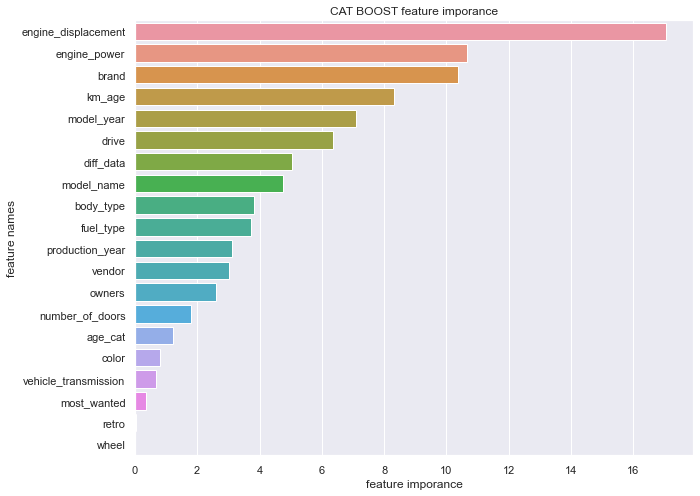

In [604]:
plot_feature_importance(model_cb.get_feature_importance(), X_train.columns, 'CAT BOOST')

In [605]:
y_pred_cb = model_cb.predict(X_test)

In [606]:
mape(y_test, y_pred_cb)*100

13.853512814437282

In [430]:
price_cut = 1000

In [431]:
y_pred_cb_ed = price_cut * np.round(y_pred_cb / price_cut)

In [432]:
mape(y_test, y_pred_cb_ed)*100

13.649062233426928

In [607]:
y_pred_cb_test = model_cb.predict(test_prep)

In [608]:
sam = pd.read_csv('data/sample_submission.csv')

In [609]:
sam['price'] = y_pred_cb_test

In [610]:
sam['price'] = sam['price'] * test_rate

In [612]:
sam.to_csv('submission20220412_7.csv', index=False)

In [611]:
sam

,sell_id,price
0,1100575026,7.621732e+05
1,1100549428,1.139229e+06
2,1100658222,9.490694e+05
3,1100937408,8.032237e+05
4,1101037972,9.741583e+05
...,...,...
34681,1101369263,1.108605e+06
34682,1101369581,2.493720e+06
34683,1101364889,2.615639e+05
34684,1101362518,1.456868e+06


### XGBRegressor

In [472]:
XG_data = data.copy()

#### Encoding categoricals, dropping cols, train-test split

In [473]:
for col in XG_data.select_dtypes('object').columns:
    XG_data[col] = XG_data[col].astype('category').cat.codes

In [474]:
X_num = XG_data.drop(['sample', 'price', 'parsed_date', 'description', 'diff_data_years'], axis=1) # pts?
y_num = XG_data['price']

In [475]:
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y_num, test_size=0.20, random_state=42, shuffle=True
)

#### training and calculating metric and importancies

In [476]:
model_xbr = train_or_load(
    xgb.XGBRegressor(
        max_depth=20, min_child_weight=1, n_estimators=500, n_jobs=-1, eta=0.11
    ),
    X_train_num,
    y_train_num,
    "models/2022-04-12_XGBRegressor.joblib",
)

In [477]:
y_pred_xbr = model_xbr.predict(X_test_num)

In [478]:
mape(y_test, y_pred_xbr)*100

14.343106789753001

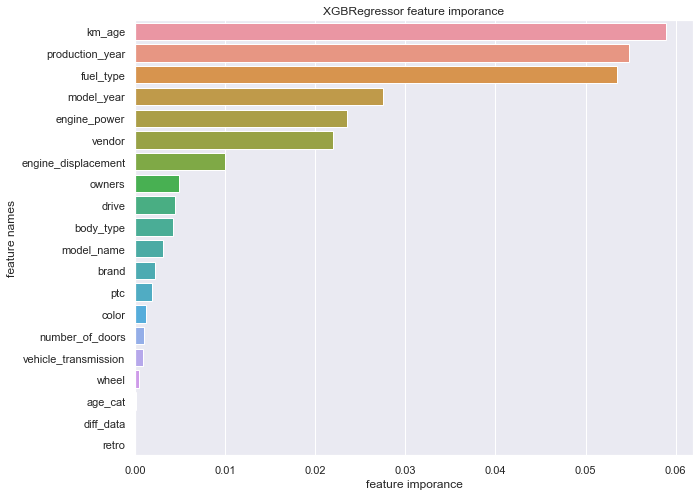

In [479]:
plot_feature_importance(model_xbr.feature_importances_, X_train_num.columns, 'XGBRegressor')

### RandomForestRegressor

In [152]:
model_rfr = train_or_load(
    RandomForestRegressor(random_state=42, n_jobs=-1, verbose=1),
    X_train_num,
    y_train_num,
    "models/2022-04-08_RandomForestRegressor_0.joblib",
)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   17.9s finished


In [153]:
y_pred_rfr = model_rfr.predict(X_test_num)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done 100 out of 100 | elapsed:    0.2s finished


In [154]:
mape(y_test, y_pred_rfr)*100

13.772104560114046

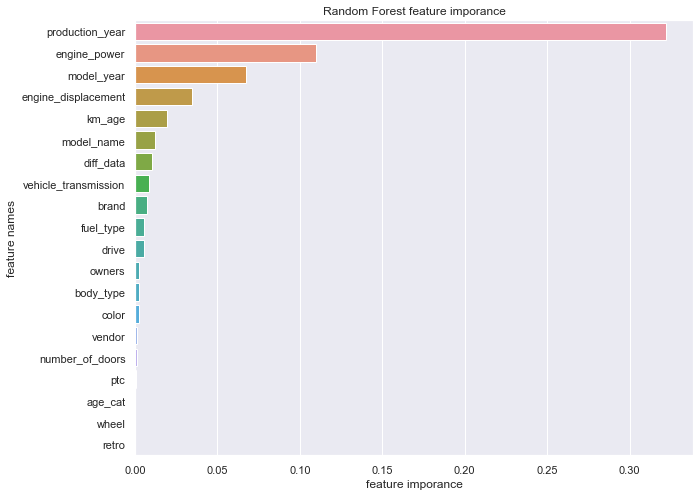

In [155]:
plot_feature_importance(model_rfr.feature_importances_, X_train_num.columns, 'Random Forest')

### AdaBoostRegressor (dummies)

In [58]:
X_train["train/test"] = "train"
X_test["train/test"] = "test"

ada_data = X_train.append(X_test)
ada_prep = ada_data.drop(columns=["train/test"]).pipe(get_dumb_dummies)

ada_train = ada_prep.loc[ada_data["train/test"] == "train"]
ada_test = ada_prep.loc[ada_data["train/test"] == "test"]

In [59]:
model_ada = train_or_load(
    AdaBoostRegressor(random_state=42),
    ada_train,
    y_train,
    "models/2022-04-08_AdaBoostRegressor_dummies.joblib",
)

In [60]:
y_pred_ada = model_ada.predict(ada_test)

In [61]:
mape(y_test, y_pred_ada)*100

405.1923288385895

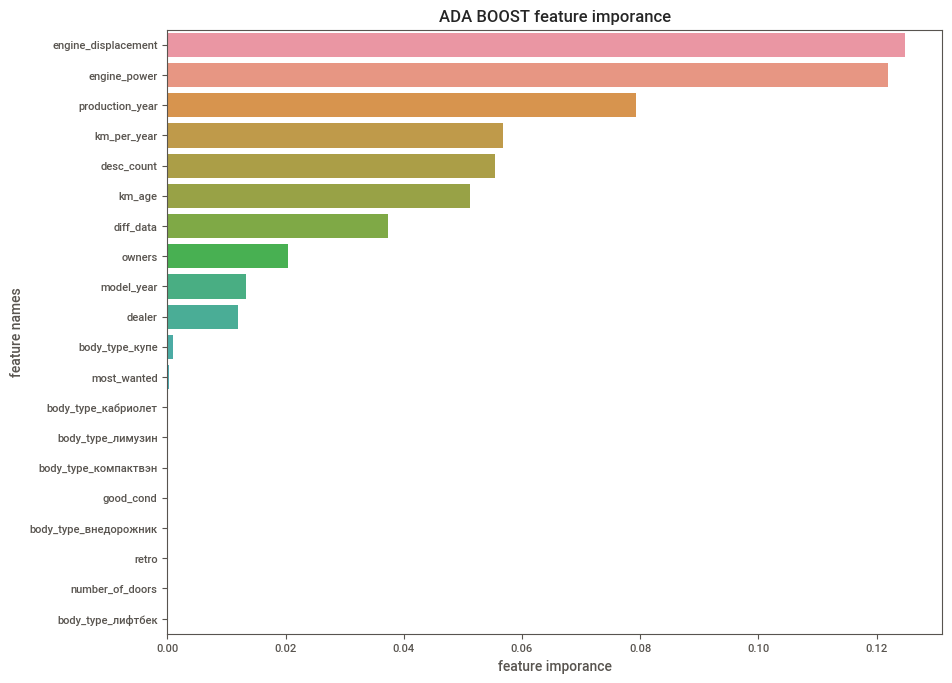

In [62]:
plot_feature_importance(model_ada.feature_importances_ , ada_train.columns, 'ADA BOOST')

### AdaBoostRegressor (ordinal)

In [63]:
model_ada = train_or_load(
    AdaBoostRegressor(random_state=42),
    X_train_num,
    y_train_num,
    "models/2022-04-08_AdaBoostRegressor_ordinal.joblib",
)

In [64]:
y_pred_ada = model_ada.predict(X_test_num)

In [65]:
mape(y_test_num, y_pred_ada)*100

562.5419084630358

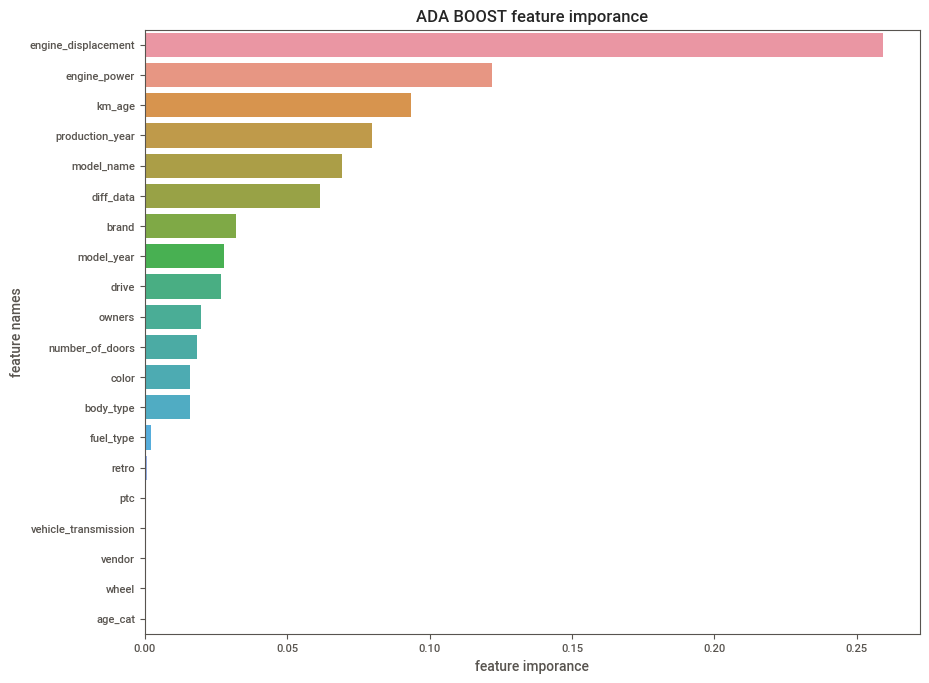

In [66]:
plot_feature_importance(model_ada.feature_importances_ , X_train_num.columns, 'ADA BOOST')

## Conclusion

1. please use new notebook for experiments, don't change this one. New files, preprocessed here, are:
  - [2022-04-08_train_pre-model.parquet](data/2022-04-08_train_pre-model.parquet)
  - [2022-04-08_test_pre-model.parquet](data/2022-04-08_test_pre-model.parquet)
2. consider keeping the most important fields, discovered by models:
  - **catboost** - engine_power, engine_displacement, production_year, brand, model_year, km_age, drive, model_name, body_type, fuel_type, diff_data, vendor
  - **xgboost** - production_year, engine_displacement, engine_power, model_year, fuel_type
  - **randomforest** - production_year, engine_displacement, engine_power, model_year, model_name, km_age
  - **adaboost** - engine_displacement, engine_power, production_year, km_per_year, desc_count, km_age, diff_data, owners, model_year, dealer
3. consider dropping adaboost or use it for stacking only
4. you can explicitly specify required fields reading parquet files
5. do a LOT of experiments:
  - try more algorythms
  - try to log or not to log **y**
  - try to standartize or not to standartize
  - try to deal with description
  - try automl
  - try ordinal vs dummy categorical encoding for different algorythms
  - try randomly drop features
6. LOG EVERYTHING - use [readme file](README.md) to log experiment results